In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import date as current_date

from fedot_ind.api.utils.checkers_collections import ApiConfigCheck
from fedot_ind.core.architecture.pipelines.abstract_pipeline import ApiTemplate
from fedot_ind.core.repository.config_repository import DEFAULT_COMPUTE_CONFIG, DEFAULT_TSF_AUTOML_CONFIG, \
    DEFAULT_TSF_LEARNING_CONFIG, DEFAULT_TSF_INDUSTRIAL_CONFIG
from fedot_ind.core.repository.constanst_repository import MONASH_FORECASTING_LENGTH
from examples.example_utils import load_monash_dataset

2025-02-25 12:14:17,761 - PyTorch version 2.2.2 available.


In [2]:
DATASET_NAME = 'fred_md'
EVAL = False

In [ ]:
monash_df = load_monash_dataset(DATASET_NAME)
features_list = list(monash_df.columns)
horizon = MONASH_FORECASTING_LENGTH[DATASET_NAME]
benchmark_dict = {DATASET_NAME: features_list}    

In [ ]:
if EVAL:
    def get_benchmark_setup(benchmark):
        print(benchmark)
        DEEPAR_LEARNING_PARAMS = {'epochs': 500, 'lr': 0.001, 'device': 'cpu'}
        TCN_LEARNING_PARAMS = {'epochs': 500, 'num_layers': 4, 'dropout': 0.01, 'num_filters': 4, 'kernel_size': MONASH_FORECASTING_LENGTH[benchmark[0]], 'weight_norm': True}
        ETS_LEARNING_PARAMS = {'seasonal': None, 'seasonal_periods': 12}
        model_to_compare = [
            {}, 
            {0: ['ets', ETS_LEARNING_PARAMS]}, 
            {0: [('tcn_model', TCN_LEARNING_PARAMS)]},
            {0: [('deepar_model', DEEPAR_LEARNING_PARAMS)]}
            ]
        model_name = ['industrial', 'ets', 'tcn', 'deepar']
        finetune_existed_model = [False, True, True, True]
        BENCHMARK = benchmark[0]
        BENCHMARK_PARAMS = {'experiment_date': current_date.today().isoformat(),
                            'metadata': MONASH_FORECASTING_LENGTH,
                            'datasets': benchmark[1],
                            'model_to_compare': (model_to_compare, model_name, finetune_existed_model)}
        
        BENCHMARK_CONFIG = {'task': 'ts_forecasting',
                        'task_params': {'forecast_length': MONASH_FORECASTING_LENGTH[benchmark[0]]},
                        'timeout': 2,
                        'n_workers': 4,
                        'threads_per_worker': 2,
                        'with_tuning': True,
                        'logging_level': 20
                        }
        
        return BENCHMARK, BENCHMARK_PARAMS, BENCHMARK_CONFIG

    API_CONFIG = {'industrial_config': DEFAULT_TSF_INDUSTRIAL_CONFIG,
                'automl_config': DEFAULT_TSF_AUTOML_CONFIG,
                'learning_config': DEFAULT_TSF_LEARNING_CONFIG,
                'compute_config': DEFAULT_COMPUTE_CONFIG}
    config_agent = ApiConfigCheck()

    if __name__ == "__main__":
        for benchmark in benchmark_dict.items():
            BENCHMARK, BENCHMARK_PARAMS, BENCHMARK_CONFIG = get_benchmark_setup(benchmark)
            UPD_API_CONFIG = config_agent.update_config_with_kwargs(config_to_update=API_CONFIG,
                                                                    **BENCHMARK_CONFIG)
            config_agent.compare_configs(API_CONFIG, UPD_API_CONFIG)
            api_agent = ApiTemplate(api_config=UPD_API_CONFIG, metric_list=('rmse', 'mae', 'mdae', 'smape', 'mase', 'mdase', 'mape'))
            api_agent.evaluate_benchmark(benchmark_name=BENCHMARK,
                                        benchmark_params=BENCHMARK_PARAMS)

In [4]:
input_folder = os.path.join('./benchmark_results', f'2025-02-24_{DATASET_NAME}')
model_list = ['industrial', 'ets', 'tcn']

result_dict = dict()
for dataset in features_list:
    model_result = dict()
    for model in model_list:
        model_result[model] = np.load(os.path.join(input_folder, model, dataset, 'results.npy'),allow_pickle='TRUE').item() 
    result_dict[dataset] = model_result

In [5]:
metrics_df = pd.DataFrame()
for dataset_result in result_dict.items(): 
    for model_result in dataset_result[1].items():
        try:
            model_df = pd.DataFrame(model_result[1]['metrics'])
            model_df['model'] = model_result[0]
            model_df['dataset'] = dataset_result[0]
            model_df['time'] = model_result[1]['time']
            model_df['length'] = len(model_result[1]['train_data'])
            model_df['speed'] = model_df['length'] / model_df['time'] 
        except:
            model_df = pd.DataFrame()
        metrics_df = pd.concat([metrics_df, model_df])
metrics_df

,rmse,mae,mdae,mase,mdase,mape,smape,model,dataset,time,length,speed
0,107.332,89.865,77.289,0.346,0.348,0.534,0.535,industrial,T1,156.994035,728,4.637119
0,547.272,546.496,552.497,2.105,2.486,3.246,3.299,ets,T1,14.233371,728,51.147405
0,294.995,248.164,300.453,0.956,1.352,1.464,1.479,tcn,T1,72.742615,728,10.007889
0,69.158,57.180,49.154,0.244,0.258,0.409,0.410,industrial,T2,178.502889,728,4.078365
0,419.290,417.588,412.982,1.785,2.170,2.985,3.031,ets,T2,11.682342,728,62.316272
...,...,...,...,...,...,...,...,...,...,...,...,...
0,564.520,542.753,481.422,2.043,3.624,3.399,3.462,ets,T106,12.553650,728,57.991104
0,426.244,322.798,237.078,1.215,1.785,2.000,2.035,tcn,T106,81.094997,728,8.977126
0,87.152,73.416,67.784,1.236,2.221,2.035,2.061,industrial,T107,168.439928,728,4.322016
0,188.985,160.772,140.422,2.706,4.602,4.447,4.587,ets,T107,13.514259,728,53.869028


In [6]:
metrics_df.groupby(['dataset']).mean()

,rmse,mae,mdae,mase,mdase,mape,smape,time,length,speed
dataset,,,,,,,,,,
T1,316.533000,294.841667,310.079667,1.135667,1.395333,1.748000,1.771000,81.323340,728.0,21.930804
T10,1.582333,1.313000,1.144333,0.764000,0.729667,1.289333,1.282000,68.303699,728.0,34.290522
T100,1.112667,1.021667,1.010000,0.441000,0.507000,1.176667,1.165000,69.864798,728.0,18.241524
T101,1.212000,1.032333,1.059333,0.591667,0.862667,1.042667,1.037667,73.966465,728.0,20.455159
T102,1.419667,1.350333,1.249667,0.766667,0.656667,1.157000,1.168000,72.379886,728.0,52.837434
...,...,...,...,...,...,...,...,...,...,...
T95,4.407667,4.139667,3.934000,0.826667,0.728333,1.283667,1.297667,77.896571,728.0,24.964778
T96,2.470667,2.349333,2.379000,0.607667,0.614667,0.926333,0.932667,108.046320,728.0,58.776280
T97,1.962333,1.805667,1.823333,0.500000,0.521000,0.774000,0.775667,79.649079,728.0,22.721982


In [8]:
metrics_df[['model', 'rmse', 'smape', 'mase', 'speed']].groupby(['model']).mean().round(2)

,rmse,smape,mase,speed
model,,,,
ets,5882.42,15.45,1.12,85.98
industrial,3575.80,11.09,0.57,3.97
tcn,3176.82,10.74,0.67,10.48


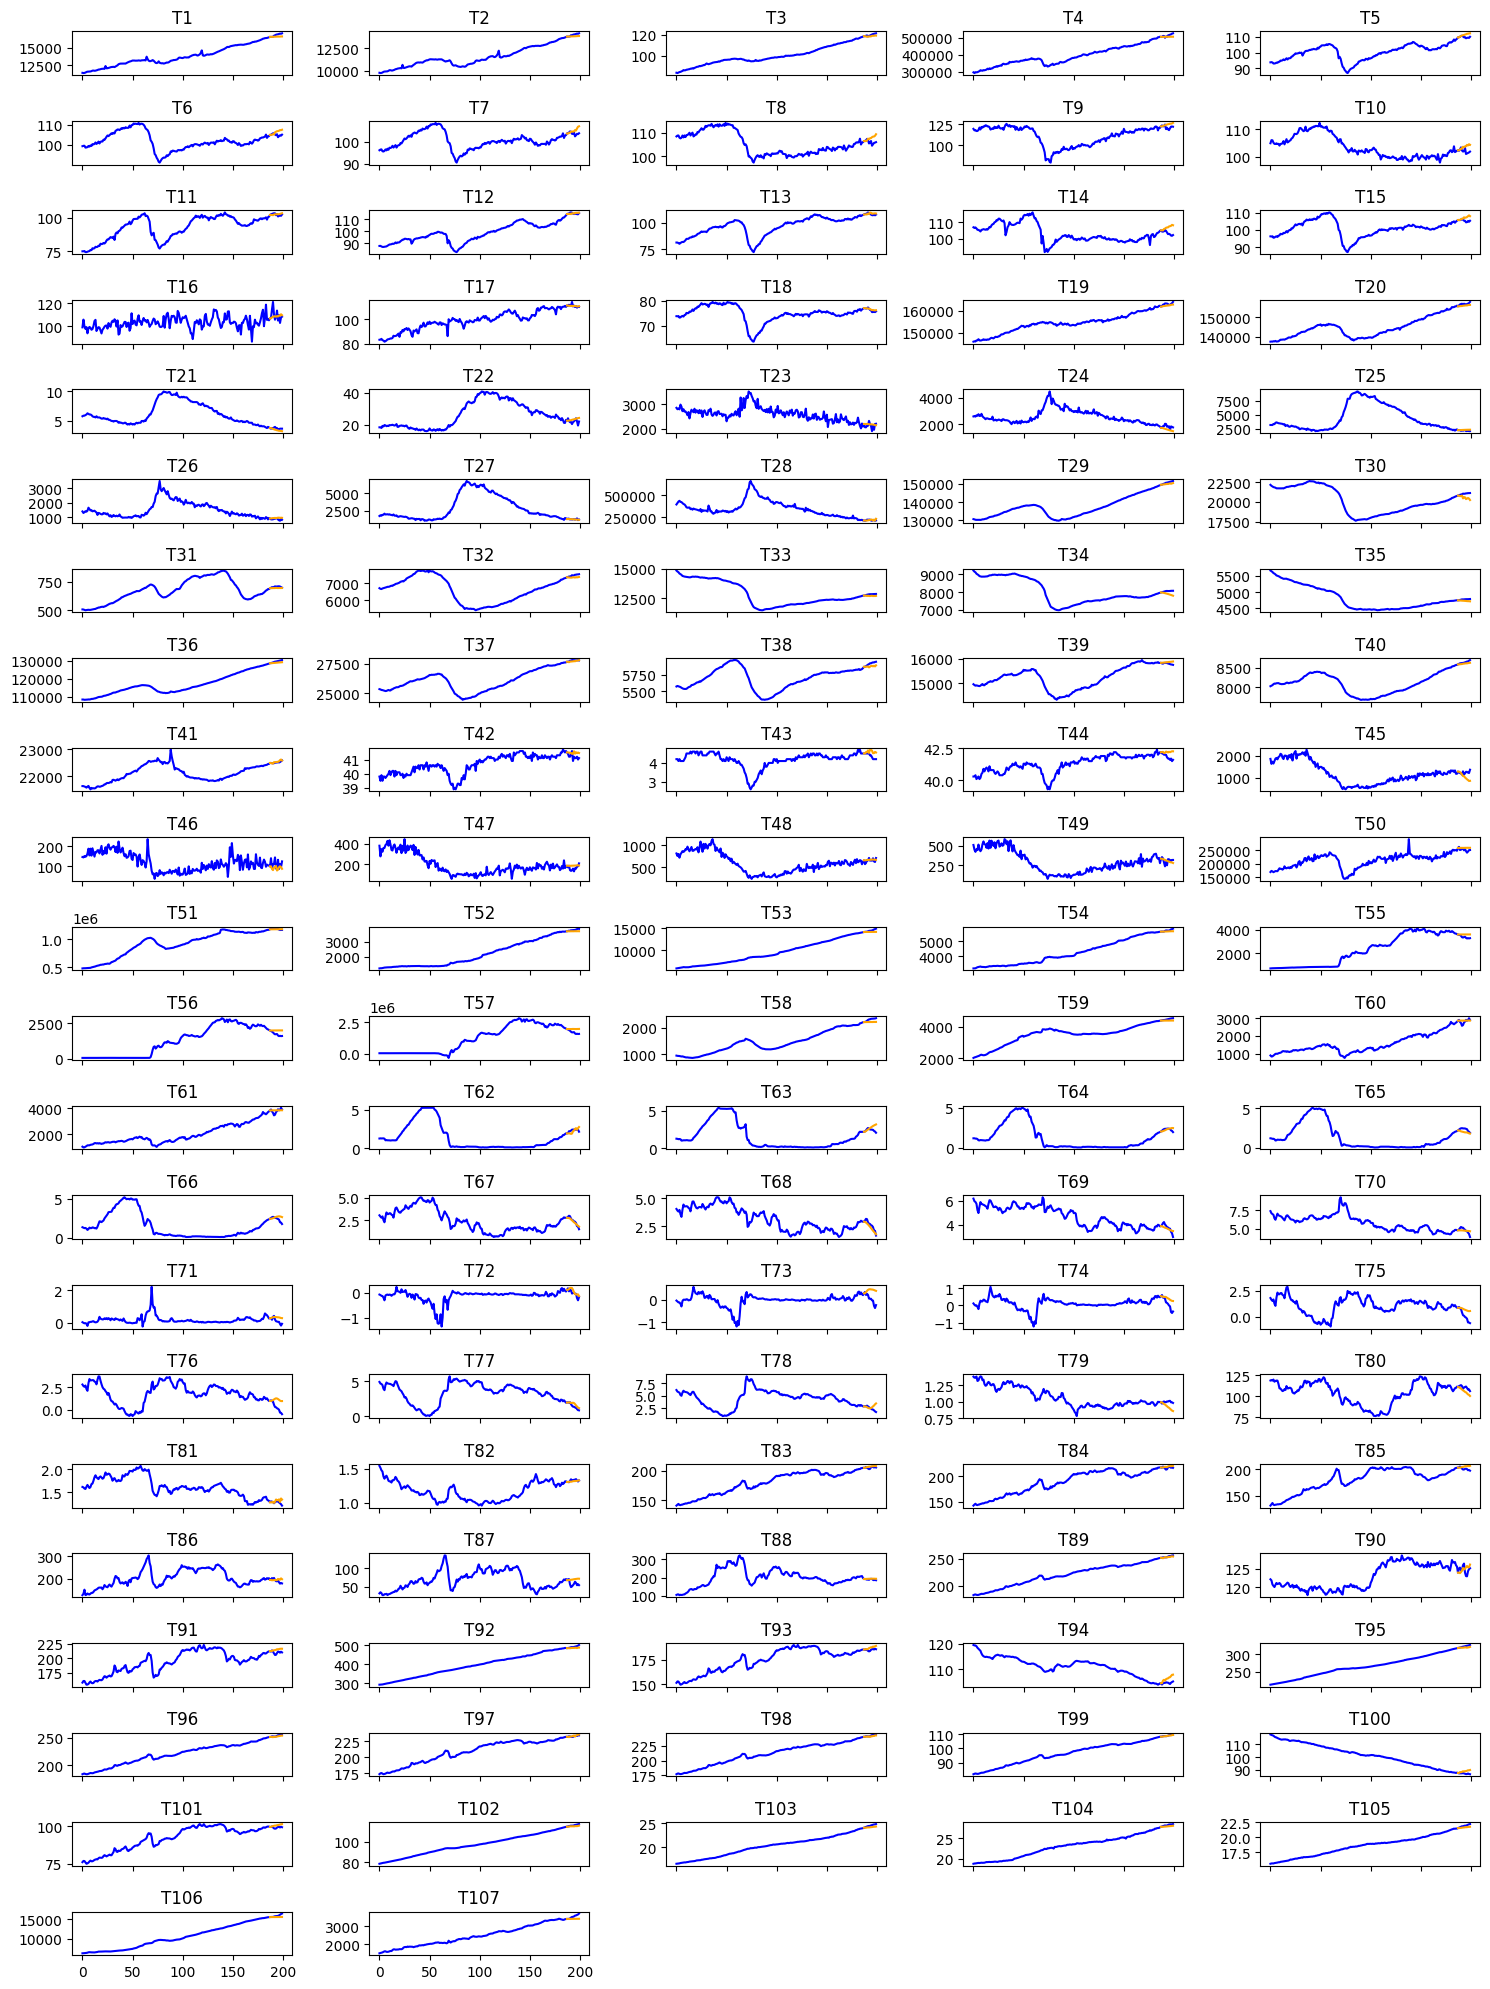

In [9]:
border = 200
fig, axes = plt.subplots(nrows=22, ncols=5, figsize=(15, 20), sharex=True, sharey=False)
axes = axes.flatten()
model_name = 'tcn'

for idx, (label, data) in enumerate(result_dict.items()):
    if idx >= len(axes):
        break
    pred_dict = data[model_name]
    real_values = pred_dict['train_data']
    try:
        eigen = pred_dict['labels']
    except:
        eigen = np.zeros(shape=horizon)
    if len(real_values) > border:
        real_values = real_values[-border:]
    indicies = np.arange(real_values.shape[0])
    ax = axes[idx]
    ax.plot(real_values, label='Real values', color='blue')
    real_last_value = real_values[-horizon - 1]
    ax.plot(indicies[-horizon - 1:],
            np.insert(eigen, 0, real_last_value), label='Forecast', color='orange')
    ax.set_title(label)

for ax in axes[len(result_dict):]:
    ax.axis('off')
    
plt.tight_layout()
plt.show()

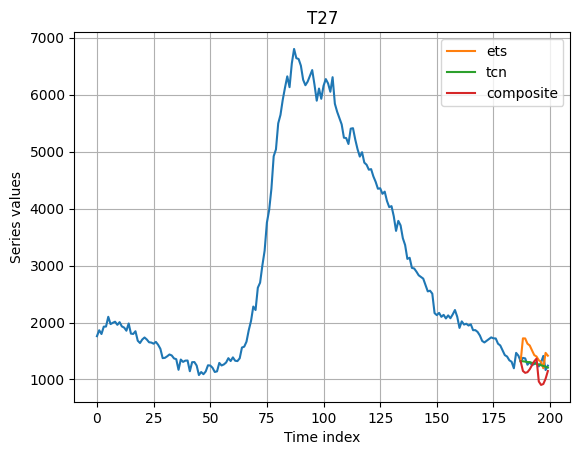

In [10]:
feature_name = 'T27'

border = 200
model_list = ['ets', 'tcn', 'industrial']
eigen_1 = result_dict[feature_name][model_list[0]]['labels']
eigen_2 = result_dict[feature_name][model_list[1]]['labels']
eigen_3 = result_dict[feature_name][model_list[2]]['labels']
plt.close()
real_values = result_dict[feature_name][model_list[0]]['train_data']

if len(real_values) > border:
        real_values = real_values[-border:]

real_values = real_values[-border:]
indicies = np.arange(real_values.shape[0])

plt.xlabel('Time index')
plt.ylabel('Series values')
plt.title(feature_name)
plt.plot(real_values)

for i, model in enumerate(model_list):
        model_list[i] = 'composite' if model == 'industrial' else model
        
real_last_value = real_values[-horizon - 1]
plt.plot(indicies[-horizon - 1:],
        np.insert(eigen_1, 0, real_last_value), label=f'{model_list[0]}')
plt.plot(indicies[-horizon - 1:],
        np.insert(eigen_2, 0, real_last_value), label=f'{model_list[1]}')
plt.plot(indicies[-horizon - 1:],
        np.insert(eigen_3, 0, real_last_value), label=f'{model_list[2]}')

plt.grid()
plt.legend()

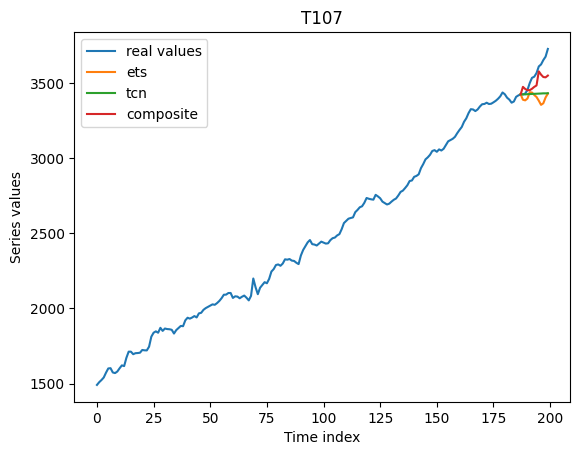

In [11]:
for feature_name in features_list:
        border = 200
        model_list = ['ets', 'tcn', 'industrial']
        eigen_1 = result_dict[feature_name][model_list[0]]['labels']
        eigen_2 = result_dict[feature_name][model_list[1]]['labels']
        eigen_3 = result_dict[feature_name][model_list[2]]['labels']
        plt.close()
        real_values = result_dict[feature_name][model_list[0]]['train_data']

        if len(real_values) > border:
                real_values = real_values[-border:]

        real_values = real_values[-border:]
        indicies = np.arange(real_values.shape[0])

        plt.xlabel('Time index')
        plt.ylabel('Series values')
        plt.title(feature_name)
        plt.plot(real_values, label='real values')
        
        for i, model in enumerate(model_list):
                model_list[i] = 'composite' if model == 'industrial' else model
                
        real_last_value = real_values[-horizon - 1]
        plt.plot(indicies[-horizon - 1:],
                np.insert(eigen_1, 0, real_last_value), label=f'{model_list[0]}')
        plt.plot(indicies[-horizon - 1:],
                np.insert(eigen_2, 0, real_last_value), label=f'{model_list[1]}')
        plt.plot(indicies[-horizon - 1:],
                np.insert(eigen_3, 0, real_last_value), label=f'{model_list[2]}')


        plt.legend()
        images_path = os.path.join('./benchmark_results', 'images', DATASET_NAME)
        os.makedirs(images_path, exist_ok=True)
        plt.savefig(os.path.join(images_path, f'{feature_name}.png'), dpi=fig.dpi)